<a href="https://colab.research.google.com/github/mattbarrett98/mikit-learn/blob/main/MyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Classification project on MNIST handwritten digits dataset. We will try to code all algorithms from scratch- everything from k nearest neighbours to convolutional neural networks with batch normalisation

11501568/11490434 [==============================] - 0s 0us/step


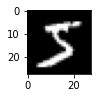

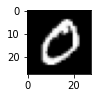

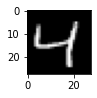

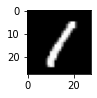

In [ ]:
from keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, BatchNormalization
import numpy as np
from matplotlib import pyplot
import random as rnd
from numpy.random import normal as norm

#load data and plot first 4 images
(train_X, train_y), (test_X, test_y) = mnist.load_data()
for i in range(4):  
  pyplot.subplot(330 + 1 + i)
  pyplot.imshow(train_X[i], cmap=pyplot.get_cmap('gray'))
  pyplot.show()

#divide by 255 to normalise to [0,1] to ensure all variables on the same scale
traindata = (train_X/255).reshape(60000, 784)
testdata = (test_X/255).reshape(10000, 784) 

#one hot encoding is necessary for certain algorithms
Y = np.zeros((traindata.shape[0],len(set(train_y))))
for i in range(len(Y)):
  Y[i, train_y[i]]=1 

6 Multilayer perceptron



In [ ]:
def softmax(x):
  p = np.exp(x)
  return p / np.sum(p, axis=0)

def relu(x):
  return (x + abs(x))/2  

#2 hidden layers so we have 3 sets of weights and biases
def mlp_grad(batch, truth, w1, w2, w3, b1, b2, b3):
  z1 = np.matmul(w1, batch) + b1[:,np.newaxis]
  a1 = relu(z1)
  z2 = np.matmul(w2, a1) + b2[:,np.newaxis]
  a2 = relu(z2)
  #output of neural network
  a3 = softmax(np.matmul(w3, a2) + b3[:,np.newaxis])
  #calculate gradients using the chain rule/backpropogation - categorical cross entropy is our loss
  inter1 = a3 - truth
  grad_b3 = np.sum(inter1, axis=1)
  grad_w3 = np.matmul(inter1, a2.T)
  inter2 = np.matmul(w3.T, inter1) * np.sign(a2)
  grad_b2 = np.sum(inter2, axis=1)
  grad_w2 = np.matmul(inter2, a1.T)
  inter3 = np.matmul(w2.T, inter2) * np.sign(a1)
  grad_b1 = np.sum(inter3, axis=1)
  grad_w1 = np.matmul(inter3, batch.T)
  return grad_w1, grad_w2, grad_w3, grad_b1, grad_b2, grad_b3

#basic gradient descent algorithm  
def gradient_descent(batch,truth, par, learning_rate):
  grad = mlp_grad(batch, truth, par[0], par[1], par[2], par[3], par[4], par[5])
  par = [a - learning_rate*b for a,b in zip(par,grad)]
  return par 

def mini_batch_sgd(X, Y, epochs, batch_size, l2, l3, l4):
  #He initialisation since we are using relu activations
  par = [np.random.normal(0, np.sqrt(1/X.shape[0]), (l2,X.shape[0])), np.random.normal(0, np.sqrt(2/l2), (l3,l2)), np.random.normal(0, np.sqrt(2/l3), (l4,l3)), np.zeros(l2), np.zeros(l3), np.zeros(l4)]
  #loop through entire dataset 'epochs' times
  for i in range(epochs):
    #in each epoch perform gradient descent on each mini batch
    for j in range(int(np.ceil(X.shape[1]/batch_size))):
      batch = X[:, batch_size*j:batch_size*(j+1)]
      truth = Y[:, batch_size*j:batch_size*(j+1)]
      par = gradient_descent(batch, truth, par, 0.01)
  return par[0], par[1], par[2], par[3], par[4], par[5]

#train network
a,b,c,d,e,f = mini_batch_sgd(traindata.T, Y.T, 30, 16, 128, 64, 10)

#make predictions and output accuracy
z1 = np.matmul(a, testdata.T) + d[:,np.newaxis]
a1 = relu(z1)
z2 = np.matmul(b, a1) + e[:,np.newaxis]
a2 = relu(z2)
a3 = softmax(np.matmul(c, a2) + f[:,np.newaxis])
sum(np.argmax(a3, axis=0)==test_y)/test_y.shape[0]  

0.9765

check tensorflow gives a similar result (architecture is the same as is epochs, batch size etc)

In [ ]:
model = Sequential()
model.add(Dense(128, input_dim=784, activation='relu'))
model.add(Dense(64, 'relu'))
model.add(Dense(10, 'softmax'))
model.compile(loss='categorical_crossentropy', optimizer='SGD')
model.fit(traindata, Y, epochs=30, batch_size=16, verbose=0)
pred = model.predict(testdata)
sum(np.argmax(np.array(pred), axis=1)==test_y)/test_y.shape[0]

0.9778

7 Convolutional neural network (with batch normalisation)

In [ ]:
#cnn architecture: conv layer with 16 5x5 filters (relu) -> 2x2 maxpool -> batch norm 
#-> conv layer with 32 5x5 filters (relu) -> 2x2 maxpool -> batch norm -> flatten
#-> 256 dense layer (relu) -> batch norm -> 10 unit dense output layer (softmax)

filter1, filter2, filter_size, dense, momentum = 16, 32, 5, 256, 0.99
def cnn_grad(batch, truth, f1, b1, gamma1, beta1, mu1_MA, var1_MA, f2, b2, gamma2, beta2, mu2_MA, var2_MA, w1, b3, gamma3, beta3, mu3_MA, var3_MA, w2, b4):
  size = batch.shape[0]
  #first we pad the input with zeros
  batch = np.pad(batch, ((0,0),(2,2),(2,2)))
  #first convolutional layer 
  arr1 = np.empty((filter_size**2, size, 28, 28))
  for i in range(filter_size**2):
    arr1[i,:,:,:] = batch[:, i//5:i//5 + 28, i%5:i%5 + 28]
  c1 = np.tensordot(f1, arr1, axes=((1),(0))) + b1.reshape(filter1,1,1,1) 
  c1 = relu(c1) 
  #first max pooling layer
  s1 = filter1*size*196
  z1 = np.arange(s1)
  res1 = np.swapaxes(c1.reshape(filter1,size,14,2,14,2),3,4).reshape(s1,4)
  arg1 = np.argmax(res1, axis=1)
  mp1 = res1[z1, arg1].reshape(filter1,size,14,14)
  #first batch normalisation
  mu1 = np.mean(mp1, axis=(1,2,3))
  m1 = size*196
  xmu1 = mp1-mu1.reshape(filter1,1,1,1)
  var1 =  np.sum(xmu1**2, axis=(1,2,3))/m1
  invsd1 = 1/np.sqrt(var1.reshape(filter1,1,1,1) + 0.001)
  x_hat1 = (mp1 - mu1.reshape(filter1,1,1,1)) * invsd1
  bn1 = gamma1.reshape(filter1,1,1,1)*x_hat1 + beta1.reshape(filter1,1,1,1)
  #update moving averages for mean and var (momentum=0.99)
  mu1_MA = momentum*mu1_MA + (1-momentum)*mu1
  var1_MA = momentum*var1_MA + (1-momentum)*var1
  #pad with zeros
  padded = np.pad(bn1, ((0,0),(0,0),(2,2),(2,2)))
  #second convolutional layer 
  arr2=np.empty((filter_size**2,filter1,size,14,14))
  for i in range(filter_size**2):
    arr2[i,:,:,:,:] = padded[:,:, i//5:i//5 + 14, i%5:i%5 + 14]
  c2 = np.tensordot(f2, arr2, axes=((1,2), (1,0))) + b2.reshape(filter2,1,1,1)
  c2 = relu(c2)
  #second max pooling layer
  s2 = filter2*size*49
  z2 = np.arange(s2)
  res2 = np.swapaxes(c2.reshape(filter2,size,7,2,7,2),3,4).reshape(s2,4)
  arg2 = np.argmax(res2, axis=1)
  mp2 = res2[z2, arg2].reshape(filter2,size,7,7)
  #second batch normalisation
  m2 = 49*size
  mu2 = np.mean(mp2, axis=(1,2,3))
  xmu2 = mp2-mu2.reshape(filter2,1,1,1)
  var2 =  np.sum(xmu2**2, axis=(1,2,3))/m2
  invsd2 = 1/np.sqrt(var2.reshape(filter2,1,1,1) + 0.001)
  x_hat2 = (mp2 - mu2.reshape(filter2,1,1,1)) * invsd2
  bn2 = gamma2.reshape(filter2,1,1,1)*x_hat2 + beta2.reshape(filter2,1,1,1)
  #update moving averages for mean and var (momentum=0.99)
  mu2_MA = momentum*mu2_MA + (1-momentum)*mu2
  var2_MA = momentum*var2_MA + (1-momentum)*var2
  #flatten the output
  flat = np.swapaxes(bn2, 0,1).reshape(size, -1)
  # dense layer
  d1 = np.matmul(w1, flat.T) + b3[:,np.newaxis]
  a1 = relu(d1)
  #batch norm
  mu3 = np.mean(a1, axis=1) 
  xmu3 = a1-mu3[:,np.newaxis]
  var3 = 1/size * np.sum(xmu3**2, axis=1)
  invsd3 = 1/np.sqrt(var3.reshape(dense,1) + 0.001)
  x_hat3 = (a1 - mu3.reshape(dense,1))*invsd3
  bn3 = gamma3.reshape(dense,1)*x_hat3 + beta3.reshape(dense,1)
  #moving averages
  mu3_MA = momentum*mu3_MA + (1-momentum)*mu3
  var3_MA = momentum*var3_MA + (1-momentum)*var3
  #final layer with softmax activation
  a2 = softmax(np.matmul(w2, bn3) + b4[:,np.newaxis])
  #gradient via backprop - categorical cross entropy loss
  inter1 = a2 - truth
  db4 = np.sum(inter1, axis=1)
  dw2 = np.matmul(inter1, bn3.T)
  inter2 = np.matmul(w2.T, inter1)
  dbeta3 = np.sum(inter2, axis=1)
  dgam3 = np.sum(inter2*x_hat3, axis=1)
  dxhat3 = inter2*gamma3[:,np.newaxis]
  dsig3 = np.sum(dxhat3*xmu3, axis=1) * 0.5 * (invsd3.reshape(dense)**3)
  dmu3 = np.sum(dxhat3*-invsd3, axis=1) + dsig3*np.sum(-2*xmu3, axis=1)/size
  inter3 = (dxhat3*invsd3 + dsig3[:,np.newaxis]*2*xmu3/size + dmu3[:,np.newaxis]/size) * np.sign(a1)
  db3 = np.sum(inter3, axis=1)
  dw1 = np.matmul(inter3, flat)
  inter4 = np.swapaxes(np.matmul(w1.T, inter3).T.reshape(size,filter2,7,7),0,1)
  dbeta2 = np.sum(inter4, axis=(1,2,3))
  dgam2 = np.sum(inter4*x_hat2, axis=(1,2,3))
  dxhat2 = inter4*gamma2.reshape(filter2,1,1,1)
  dsig2 = np.sum(dxhat2*xmu2, axis=(1,2,3)) * 0.5 * (invsd2.reshape(filter2)**3)
  dmu2 = np.sum(dxhat2*-invsd2, axis=(1,2,3)) + dsig2*np.sum(-2*xmu2, axis=(1,2,3))/m2
  inter5 = dxhat2*invsd2 + dsig2.reshape(filter2,1,1,1)*2*xmu2/m2 + dmu2.reshape(filter2,1,1,1)/m2
  mp_grad2 = np.zeros((s2,4))
  mp_grad2[z2,arg2] = inter5.ravel()
  mp_grad2 = np.swapaxes(mp_grad2.reshape(filter2,size,7,7,2,2),3,4).reshape(filter2,size,14,14)
  inter6 = mp_grad2*np.sign(c2)
  db2 = np.sum(inter6, axis=(1,2,3))
  df2 = np.swapaxes(np.tensordot(inter6, arr2, axes=((1,2,3),(2,3,4))),1,2)
  f2_prime = np.rot90(f2.reshape(filter2,filter1,5,5), 2, axes=(2,3))
  pad = np.pad(inter6, ((0,0),(0,0),(2,2),(2,2)))
  sub = np.empty((filter_size**2,filter2,size,14,14))
  for i in range(filter_size**2):
    sub[i,:,:,:,:] = pad[:,:, i//5:i//5 + 14, i%5:i%5 + 14]
  inter7 = np.tensordot(f2_prime.reshape(filter2,filter1,filter_size**2), sub, axes=((0,2),(1,0)))
  dbeta1 = np.sum(inter7, axis=(1,2,3))
  dgam1 = np.sum(inter7*x_hat1, axis=(1,2,3))
  dxhat1 = inter7*gamma1.reshape(filter1,1,1,1)
  dsig1 = np.sum(dxhat1*xmu1, axis=(1,2,3)) * 0.5 * (invsd1.reshape(filter1)**3)
  dmu1 = np.sum(dxhat1*-invsd1, axis=(1,2,3)) + dsig1*np.sum(-2*xmu1, axis=(1,2,3))/m1
  inter8 = dxhat1*invsd1 + dsig1.reshape(filter1,1,1,1)*2*xmu1/m1 + dmu1.reshape(filter1,1,1,1)/m1
  mp_grad1 = np.zeros((s1,4))
  mp_grad1[z1,arg1] = inter8.ravel()
  mp_grad1 = np.swapaxes(mp_grad1.reshape(filter1,size,14,14,2,2),3,4).reshape(filter1,size,28,28)
  inter9 = mp_grad1*np.sign(c1)
  db1 = np.sum(inter9, axis=(1,2,3))
  df1 = np.tensordot(inter9, arr1, axes=((1,2,3),(1,2,3)))
  return [df1,db1,dgam1,dbeta1,df2,db2,dgam2,dbeta2,dw1,db3,dgam3,dbeta3,dw2,db4],mu1_MA,var1_MA,mu2_MA,var2_MA,mu3_MA,var3_MA
  

#vanilla gradient descent 
def gd(batch,truth,p,mu1,var1,mu2,var2,mu3,var3,learning_rate):
  grad,mu1,var1,mu2,var2,mu3,var3 = cnn_grad(batch, truth,p[0],p[1],p[2],p[3],mu1, var1, p[4], p[5], p[6], p[7], mu2, var2, p[8], p[9], p[10], p[11], mu3, var3, p[12], p[13]) 
  p = [a - learning_rate*b for a,b in zip(p,grad)]
  return p,mu1,var1,mu2,var2,mu3,var3

def mini_batch_sgd(X, Y, epochs, batch_size):
  p,mu1,var1,mu2,var2,mu3,var3 = [np.random.uniform(-np.sqrt(6/(filter_size**2+filter1)), np.sqrt(6/(filter_size**2+filter1)), (filter1, filter_size**2)),np.zeros(filter1),np.ones(filter1),np.zeros(filter1),np.random.uniform(-np.sqrt(6/(filter1*filter_size**2+filter2)), np.sqrt(6/(filter1*filter_size**2+filter2)), (filter2, filter1, filter_size**2)),np.zeros(filter2),np.ones(filter2),np.zeros(filter2), np.random.uniform(-np.sqrt(6/(filter2*49 + dense)),np.sqrt(6/(filter2*49 + dense)), (dense, filter2*49)),np.zeros(dense),np.ones(dense),np.zeros(dense),np.random.uniform(-np.sqrt(6/(dense+10)), np.sqrt(6/(dense+10)), (10,dense)),np.zeros(10)],0,1,0,1,0,1 
  
  #loop through entire dataset 'epochs' times
  for i in range(epochs):
    #in each epoch perform gradient descent on each mini batch
    perm = np.random.permutation(X.shape[0])
    X = X[perm, :, :]
    Y = Y[:, perm]
    for j in range(int(np.ceil(X.shape[0]/batch_size))):
      batch = X[batch_size*j:batch_size*(j+1),:,:]
      truth = Y[:, batch_size*j:batch_size*(j+1)]
      p,mu1,var1,mu2,var2,mu3,var3 = gd(batch, truth, p, mu1, var1, mu2, var2, mu3, var3, 0.005)
  return p,mu1,var1,mu2,var2,mu3,var3

#train network
p, mu1, var1, mu2, var2, mu3, var3 = mini_batch_sgd(train_X, Y.T, 16, 32)  

#make predictions
pred=np.empty(10000)
for j in range(10):
  size = test_X[j*1000:1000*(j+1)].shape[0]
  batch = np.pad(test_X[1000*j:1000*(j+1)], ((0,0),(2,2),(2,2)))
  arr1 = np.empty((25, size, 28, 28))
  for i in range(25):
     arr1[i,:,:,:] = batch[:, i//5:i//5 + 28, i%5:i%5 + 28]
  c1 = np.tensordot(p[0], arr1, axes=((1),(0))) + p[1].reshape(filter1,1,1,1) 
  c1 = relu(c1) 
  mp1 = c1.reshape(filter1,size,14,2,14,2).max(axis=(3,5))
  x_hat1 = (mp1 - mu1.reshape(filter1,1,1,1)) / np.sqrt(var1.reshape(filter1,1,1,1))
  bn1 = p[2].reshape(filter1,1,1,1)*x_hat1 + p[3].reshape(filter1,1,1,1)
  padded = np.pad(bn1, ((0,0),(0,0),(2,2),(2,2)))
  arr2=np.empty((25,filter1,size,14,14))
  for i in range(25):
    arr2[i,:,:,:,:] = padded[:,:, i//5:i//5 + 14, i%5:i%5 + 14]
  c2 = np.tensordot(p[4], arr2, axes=((1,2), (1,0))) + p[5].reshape(filter2,1,1,1)
  c2 = relu(c2)
  mp2 = c2.reshape(filter2,size,7,2,7,2).max(axis=(3,5))
  x_hat2 = (mp2 - mu2.reshape(filter2,1,1,1)) / np.sqrt(var2.reshape(filter2,1,1,1))
  bn2 = p[6].reshape(filter2,1,1,1)*x_hat2 + p[7].reshape(filter2,1,1,1)
  flat = np.swapaxes(bn2, 0,1).reshape(size, -1)
  d1 = np.matmul(p[8], flat.T) + p[9][:,np.newaxis]
  a1 = relu(d1)
  x_hat3 = (a1 - mu3.reshape(dense,1)) / np.sqrt(var3.reshape(dense,1))
  bn3 = p[10].reshape(dense,1)*x_hat3 + p[11].reshape(dense,1)  
  a2 = softmax(np.matmul(p[12], bn3) + p[13][:,np.newaxis])
  pred[j*1000:1000*(j+1)] = np.argmax(a2, axis=0)

sum(pred==test_y)/test_y.shape[0]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


0.9898

check tensorflow provides a similar answer with the same architecture, batch size, epochs, loss etc

In [ ]:
cnn = Sequential()
cnn.add(Conv2D(16, 5, padding='same', input_shape= (28,28,1), activation='relu'))
cnn.add(MaxPooling2D(2))
cnn.add(BatchNormalization())
cnn.add(Conv2D(32, 5, padding='same', activation='relu'))
cnn.add(MaxPooling2D(2))
cnn.add(BatchNormalization())
cnn.add(Flatten())
cnn.add(Dense(256, 'relu'))
cnn.add(BatchNormalization())
cnn.add(Dense(10, activation='softmax'))
cnn.compile(optimizer='sgd', loss='categorical_crossentropy')
cnn.fit(train_X[:,:,:,np.newaxis], Y, batch_size=32, epochs=16, verbose=0)
pred = cnn.predict(test_X[:,:,:,np.newaxis])
sum(np.argmax(np.array(pred), axis=1)==test_y)/test_y.shape[0]

0.9912